In [282]:
!pip install pandas matplotlib

# Dependências
import requests
import zipfile
import io
import pandas as pd
import unicodedata
import re
import matplotlib


In [283]:
pd.options.display.max_columns = None

#### Dados Votação

In [284]:
# Download do arquivo ZIP em memória
response = requests.get("https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2022_RN.zip" )
if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        csv_file = [file for file in z.namelist() if file.endswith(".csv")][0]
        with z.open(csv_file) as f:
            df_votos = pd.read_csv(f, encoding="ISO-8859-1", sep=";")
else:
    print(f"Falha ao baixar o arquivo. Código de status: {response.status_code}")

In [285]:
df_votos.drop(df_votos.loc[df_votos['DS_CARGO']!='DEPUTADO FEDERAL'].index, inplace=True)
df_votos.head(1)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,SG_UF,SG_UE,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,CD_CARGO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,SQ_CANDIDATO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO
9,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,16217,AREIA BRANCA,32,24,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,3,1155,200001608805,ESCOLA MUNICIPAL COMERCIAL PROFESSORA GERALDA ...,"RUA JORGE CAMINHA, 118"


#### Dados Censitários - Por Distritos

In [286]:
'''
DPOs = Domicílios Particulares Ocupados
'''

df_distritos = pd.read_csv('Bases/Distritos.csv').rename(columns={'v0001': 'Pessoas',
                                                                  'v0002': 'Domicílios',
                                                                  'v0003': 'Domicílios Particulares',
                                                                  'v0004': 'Domicílios Coletivos',
                                                                  'v0005': 'Média de moradores em DPOs',
                                                                  'v0006': 'Percentual de DPOs Imputados',
                                                                  'v0007': 'Domicílios Particulares Ocupados'
                                                                  })
df_distritos.head(1)

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,CD_DIST,NM_MUN,NM_DIST,Total_setores,Pessoas,Domicílios,Domicílios Particulares,Domicílios Coletivos,Média de moradores em DPOs,Percentual de DPOs Imputados,Domicílios Particulares Ocupados
0,2,Nordeste,24,Rio Grande do Norte,2400109,240010905,Acari,Acari,28,10597,4750,4747,3,2.768747,0.996329,3814


In [287]:
df_renda = pd.read_csv('Bases/Rendimento.csv').rename(columns={'Total': 'Total Indivíduos'})
df_renda.head()

,Distrito,Total Indivíduos,Até 1/2,Mais de 1/2 a 1,Mais de 1 a 2,Mais de 2 a 5,Mais de 5 a 10,Mais de 10 a 20,Mais de 20,Sem rendimento,Código da Unidade Geográfica
0,Total,2675748,288918,717278,323928,175559,60684,22246,7715,1078875,24
1,Acari,9537,1024,3101,1001,478,115,31,7,3779,2400109
2,Açu,44769,5554,13101,4715,2331,625,167,53,18208,2400208
3,Afonso Bezerra,8927,1789,2442,656,211,24,11,3,3791,2400307
4,Água Nova,2533,333,662,160,63,6,0,0,1309,2400406


In [288]:
df_censitario = pd.merge(df_distritos, df_renda, left_on='NM_DIST', right_on='Distrito', how='inner')
df_censitario.head()

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,CD_DIST,NM_MUN,NM_DIST,Total_setores,Pessoas,Domicílios,Domicílios Particulares,Domicílios Coletivos,Média de moradores em DPOs,Percentual de DPOs Imputados,Domicílios Particulares Ocupados,Distrito,Total Indivíduos,Até 1/2,Mais de 1/2 a 1,Mais de 1 a 2,Mais de 2 a 5,Mais de 5 a 10,Mais de 10 a 20,Mais de 20,Sem rendimento,Código da Unidade Geográfica
0,2,Nordeste,24,Rio Grande do Norte,2400109,240010905,Acari,Acari,28,10597,4750,4747,3,2.768747,0.996329,3814,Acari,9537,1024,3101,1001,478,115,31,7,3779,2400109
1,2,Nordeste,24,Rio Grande do Norte,2400208,240020805,Açu,Açu,104,56496,24138,24103,35,2.932901,1.890418,19255,Açu,44769,5554,13101,4715,2331,625,167,53,18208,2400208
2,2,Nordeste,24,Rio Grande do Norte,2400307,240030705,Afonso Bezerra,Afonso Bezerra,25,10839,4339,4334,5,3.211385,0.177883,3373,Afonso Bezerra,8927,1789,2442,656,211,24,11,3,3791,2400307
3,2,Nordeste,24,Rio Grande do Norte,2400406,240040605,Água Nova,Água Nova,4,2946,1199,1199,0,2.972755,0.201816,991,Água Nova,2533,333,662,160,63,6,0,0,1309,2400406
4,2,Nordeste,24,Rio Grande do Norte,2400505,240050505,Alexandria,Alexandria,22,13640,6043,6040,3,2.811687,0.392319,4843,Alexandria,11487,2191,3412,807,363,78,16,6,4614,2400505


In [289]:
'''
Normalizando os nomes dos distritos para eles baterem com df_votos
'''

def normalize_text(value):
    if isinstance(value, str):
        # Removendo acentos e caracteres especiais
        value = ''.join(
            char for char in unicodedata.normalize('NFD', value)
            if unicodedata.category(char) != 'Mn'
        )
        # Convertendo para letra maiúscula
        value = value.upper()
        # Removendo caracteres não-alfanuméricos exceto espaços
        value = re.sub(r'[^A-Z0-9 ]', '', value)
    return value

# Aplicando a função nas colunas
df_censitario['NM_MUN'] = df_censitario['NM_MUN'].apply(normalize_text)
df_censitario['NM_DIST'] = df_censitario['NM_DIST'].apply(normalize_text)
df_censitario.head()

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,CD_DIST,NM_MUN,NM_DIST,Total_setores,Pessoas,Domicílios,Domicílios Particulares,Domicílios Coletivos,Média de moradores em DPOs,Percentual de DPOs Imputados,Domicílios Particulares Ocupados,Distrito,Total Indivíduos,Até 1/2,Mais de 1/2 a 1,Mais de 1 a 2,Mais de 2 a 5,Mais de 5 a 10,Mais de 10 a 20,Mais de 20,Sem rendimento,Código da Unidade Geográfica
0,2,Nordeste,24,Rio Grande do Norte,2400109,240010905,ACARI,ACARI,28,10597,4750,4747,3,2.768747,0.996329,3814,Acari,9537,1024,3101,1001,478,115,31,7,3779,2400109
1,2,Nordeste,24,Rio Grande do Norte,2400208,240020805,ACU,ACU,104,56496,24138,24103,35,2.932901,1.890418,19255,Açu,44769,5554,13101,4715,2331,625,167,53,18208,2400208
2,2,Nordeste,24,Rio Grande do Norte,2400307,240030705,AFONSO BEZERRA,AFONSO BEZERRA,25,10839,4339,4334,5,3.211385,0.177883,3373,Afonso Bezerra,8927,1789,2442,656,211,24,11,3,3791,2400307
3,2,Nordeste,24,Rio Grande do Norte,2400406,240040605,AGUA NOVA,AGUA NOVA,4,2946,1199,1199,0,2.972755,0.201816,991,Água Nova,2533,333,662,160,63,6,0,0,1309,2400406
4,2,Nordeste,24,Rio Grande do Norte,2400505,240050505,ALEXANDRIA,ALEXANDRIA,22,13640,6043,6040,3,2.811687,0.392319,4843,Alexandria,11487,2191,3412,807,363,78,16,6,4614,2400505


#### Dados Unificados

In [290]:
df_unificado = pd.merge(df_votos, df_censitario, left_on='NM_MUNICIPIO', right_on='NM_DIST', how='inner')
df_unificado.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,SG_UF,SG_UE,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,CD_CARGO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,SQ_CANDIDATO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,CD_DIST,NM_MUN,NM_DIST,Total_setores,Pessoas,Domicílios,Domicílios Particulares,Domicílios Coletivos,Média de moradores em DPOs,Percentual de DPOs Imputados,Domicílios Particulares Ocupados,Distrito,Total Indivíduos,Até 1/2,Mais de 1/2 a 1,Mais de 1 a 2,Mais de 2 a 5,Mais de 5 a 10,Mais de 10 a 20,Mais de 20,Sem rendimento,Código da Unidade Geográfica
0,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,16217,AREIA BRANCA,32,24,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,3,1155,200001608805,ESCOLA MUNICIPAL COMERCIAL PROFESSORA GERALDA ...,"RUA JORGE CAMINHA, 118",2,Nordeste,24,Rio Grande do Norte,2401107,240110705,AREIA BRANCA,AREIA BRANCA,42,24093,11691,11680,11,2.942442,2.835146,8183,Areia Branca,21514,2118,5343,2759,1575,376,55,8,9276,2401107
1,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,18279,SANTANA DO MATOS,18,119,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,85,1147,200001608805,ESCOLA MUNICIPAL LUIZ LIBERALINO DE CARVALHO,"POVOADO BOM JESUS, S/N",2,Nordeste,24,Rio Grande do Norte,2411403,241140305,SANTANA DO MATOS,SANTANA DO MATOS,17,8688,4192,4190,2,2.769525,0.127510,3137,Santana do Matos,11873,2175,3384,598,230,46,9,5,5426,2411403
2,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,17612,NATAL,4,308,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,5,1546,200001608805,ESCOLA ESTADUAL ANTONIO PINTO DE MEDEIROS,"RUA RIO PARANAPANEMA, S/N - CONJUNTO CIDADE SA...",2,Nordeste,24,Rio Grande do Norte,2408102,240810205,NATAL,NATAL,1116,751300,337029,336655,374,2.772461,3.632069,270507,Natal,695027,32863,165649,115979,73350,32817,14692,5692,253853,2408102
3,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,17493,MAXARANGUAPE,64,39,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,43,1066,200001608805,ESCOLA MUNICIPAL PROFESSOR ESMERINO GOMES DE S...,"RUA DA MACAÍBA, SN - PRAIA DE CARAUBAS",2,Nordeste,24,Rio Grande do Norte,2407500,240750005,MAXARANGUAPE,MAXARANGUAPE,23,10255,5576,5564,12,3.181790,0.590429,3218,Maxaranguape,8365,1154,2473,761,216,55,18,6,3682,2407500
4,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,17876,PAU DOS FERROS,40,89,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,1,1139,200001608805,ESCOLA ESTADUAL TEOFILO REGO,"RUA DA INDEPENDENCIA, 60",2,Nordeste,24,Rio Grande do Norte,2409407,240940705,PAU DOS FERROS,PAU DOS FERROS,41,30479,13051,13041,10,2.805045,1.938416,10782,Pau dos Ferros,23678,2364,7629,2585,1603,460,128,39,8869,2409407


#### Análise Exploratória

##### Dados Faltantes

Como a base com informações de renda é de 2010 e a base com informações censitárias é de 2022, há divergências na nomeclatura de alguns municípios e distritos. O jeito que escolhemos tratar essas divergências foi dropando as linhas referentes à municípios que só aparecem em uma das bases para evitar possíveis conflitos. Por conta disso esses dados vão estar faltando nas análises realizadas neste trabalho.

In [291]:
# Procurando dados faltantes no df unificado

missing_data_summary = df_unificado.isnull().sum()
missing_data_summary

DT_GERACAO                             0
HH_GERACAO                             0
ANO_ELEICAO                            0
CD_TIPO_ELEICAO                        0
NM_TIPO_ELEICAO                        0
NR_TURNO                               0
CD_ELEICAO                             0
DS_ELEICAO                             0
DT_ELEICAO                             0
TP_ABRANGENCIA                         0
SG_UF                                  0
SG_UE                                  0
NM_UE                                  0
CD_MUNICIPIO                           0
NM_MUNICIPIO                           0
NR_ZONA                                0
NR_SECAO                               0
CD_CARGO                               0
DS_CARGO                               0
NR_VOTAVEL                             0
NM_VOTAVEL                             0
QT_VOTOS                               0
NR_LOCAL_VOTACAO                       0
SQ_CANDIDATO                           0
NM_LOCAL_VOTACAO

Existem 4843 dados faltantes na coluna "Percentual de DPOs Imputados", mas como provavelmente não precisaremos utilizar esses dados nas análises futuras, escolhemos manter as linhas com esses dados faltantes ao invés de removê-los da base de dados. Caso seja necessários realizar análises que utilizam estes dados no futuro poderemos reavaliar esta escolha.

##### Limitações dos dados

A maior limitação dos dados utilizados é o fato dos dados eleitorais e dos distritos serem de 2022, enquanto as informações sobre renda são de 2010. Isso pode levar a dificuldades futuras nas análises, uma vez que as informações podem estar desatualizadas ou até mesmo causar incompatibilidades entre as bases.

##### Necessidade de correção de problemas de padronização nas colunas

Os nomes dos municípios e distritos na base do IBGE estavam escritos com acentos e apenas a primeira letra maiúscula, enquanto na base de votação os nomes estavam sem caracteres especiais e completamente capitalizados, então os nomes de distritos na base censitária foi convertida para o mesmo formato da base de votação para que as duas bases pudessem ser unificadas

##### Verificação das faixas de variação dos valores das variáveis, estatísticas básicas sobre as variáveis (média, desvio padrão, etc.), valores possíveis de atributos categóricos

In [292]:
# Estatísticas básicas para variáveis numéricas, arredondadas
numeric_stats = df_unificado.describe().round(2)

# Estatísticas adicionais: média, desvio padrão e faixa, arredondadas
additional_stats = df_unificado.select_dtypes(include=['number']).agg(['mean', 'std', 'min', 'max']).round(2)

# Valores únicos para variáveis categóricas
categorical_values = {col: df_unificado[col].unique() for col in df_unificado.select_dtypes(include=['object']).columns}

In [293]:
numeric_stats

,ANO_ELEICAO,CD_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,CD_MUNICIPIO,NR_ZONA,NR_SECAO,CD_CARGO,NR_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,SQ_CANDIDATO,CD_REGIAO,CD_UF,CD_MUN,CD_DIST,Total_setores,Pessoas,Domicílios,Domicílios Particulares,Domicílios Coletivos,Média de moradores em DPOs,Percentual de DPOs Imputados,Domicílios Particulares Ocupados,Total Indivíduos,Até 1/2,Mais de 1/2 a 1,Mais de 1 a 2,Mais de 2 a 5,Mais de 5 a 10,Mais de 10 a 20,Mais de 20,Sem rendimento,Código da Unidade Geográfica
count,207253.0,207253.0,207253.0,207253.0,207253.00,207253.00,207253.00,207253.0,207253.00,207253.00,207253.00,2.072530e+05,207253.0,207253.0,207253.0,2.072530e+05,207253.00,207253.00,207253.00,207253.00,207253.00,207253.00,202410.00,207253.00,207253.00,207253.00,207253.00,207253.00,207253.00,207253.00,207253.00,207253.00,207253.00,207253.0
mean,2022.0,2.0,1.0,546.0,17469.35,26.82,196.87,6.0,2574.98,6.19,1449.47,1.646088e+11,2.0,24.0,2407059.4,2.407059e+08,509.48,343215.63,154056.65,153894.48,162.17,2.86,2.72,123296.59,310265.64,15294.71,73819.30,51137.69,32722.68,14534.73,6354.82,2407.01,113936.05,2407059.4
std,0.0,0.0,0.0,0.0,655.33,23.69,169.15,0.0,2131.88,11.87,448.98,7.632819e+10,0.0,0.0,3404.2,3.404203e+05,512.89,346571.60,155402.86,155228.32,176.98,0.13,1.41,124983.19,323989.21,14759.43,77149.96,54582.97,34441.61,15482.88,7000.59,2743.41,117864.71,3404.2
min,2022.0,2.0,1.0,546.0,16004.00,1.00,1.00,6.0,10.00,1.00,1015.00,-3.000000e+00,2.0,24.0,2400109.0,2.400109e+08,4.00,1335.00,573.00,573.00,0.00,2.62,0.04,437.00,1756.00,231.00,458.00,129.00,44.00,5.00,0.00,0.00,527.00,2400109.0
25%,2022.0,2.0,1.0,546.0,17310.00,3.00,56.00,6.0,1100.00,1.00,1066.00,2.000016e+11,2.0,24.0,2403608.0,2.403608e+08,30.00,13577.00,5757.00,5752.00,6.00,2.77,1.46,4498.00,10858.00,1624.00,3100.00,917.00,363.00,75.00,15.00,5.00,4600.00,2403608.0
50%,2022.0,2.0,1.0,546.0,17612.00,20.00,128.00,6.0,2007.00,2.00,1236.00,2.000016e+11,2.0,24.0,2408102.0,2.408102e+08,327.00,243612.00,109395.00,109361.00,34.00,2.80,3.63,86922.00,172057.00,7574.00,37148.00,27655.00,22083.00,9519.00,2986.00,659.00,64393.00,2408102.0
75%,2022.0,2.0,1.0,546.0,17795.00,50.00,339.00,6.0,4422.00,6.00,1821.00,2.000016e+11,2.0,24.0,2408102.0,2.408102e+08,1116.00,751300.00,337029.00,336655.00,374.00,2.92,3.63,270507.00,695027.00,32863.00,165649.00,115979.00,73350.00,32817.00,14692.00,5692.00,253853.00,2408102.0
max,2022.0,2.0,1.0,546.0,18996.00,69.00,630.00,6.0,7799.00,335.00,2577.00,2.000017e+11,2.0,24.0,2415008.0,2.415008e+08,1116.00,751300.00,337029.00,336655.00,374.00,3.36,4.44,270507.00,695027.00,32863.00,165649.00,115979.00,73350.00,32817.00,14692.00,5692.00,253853.00,2415008.0


In [294]:
additional_stats

,ANO_ELEICAO,CD_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,CD_MUNICIPIO,NR_ZONA,NR_SECAO,CD_CARGO,NR_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,SQ_CANDIDATO,CD_REGIAO,CD_UF,CD_MUN,CD_DIST,Total_setores,Pessoas,Domicílios,Domicílios Particulares,Domicílios Coletivos,Média de moradores em DPOs,Percentual de DPOs Imputados,Domicílios Particulares Ocupados,Total Indivíduos,Até 1/2,Mais de 1/2 a 1,Mais de 1 a 2,Mais de 2 a 5,Mais de 5 a 10,Mais de 10 a 20,Mais de 20,Sem rendimento,Código da Unidade Geográfica
mean,2022.0,2.0,1.0,546.0,17469.35,26.82,196.87,6.0,2574.98,6.19,1449.47,1.646088e+11,2.0,24.0,2407059.4,2.407059e+08,509.48,343215.63,154056.65,153894.48,162.17,2.86,2.72,123296.59,310265.64,15294.71,73819.30,51137.69,32722.68,14534.73,6354.82,2407.01,113936.05,2407059.4
std,0.0,0.0,0.0,0.0,655.33,23.69,169.15,0.0,2131.88,11.87,448.98,7.632819e+10,0.0,0.0,3404.2,3.404203e+05,512.89,346571.60,155402.86,155228.32,176.98,0.13,1.41,124983.19,323989.21,14759.43,77149.96,54582.97,34441.61,15482.88,7000.59,2743.41,117864.71,3404.2
min,2022.0,2.0,1.0,546.0,16004.00,1.00,1.00,6.0,10.00,1.00,1015.00,-3.000000e+00,2.0,24.0,2400109.0,2.400109e+08,4.00,1335.00,573.00,573.00,0.00,2.62,0.04,437.00,1756.00,231.00,458.00,129.00,44.00,5.00,0.00,0.00,527.00,2400109.0
max,2022.0,2.0,1.0,546.0,18996.00,69.00,630.00,6.0,7799.00,335.00,2577.00,2.000017e+11,2.0,24.0,2415008.0,2.415008e+08,1116.00,751300.00,337029.00,336655.00,374.00,3.36,4.44,270507.00,695027.00,32863.00,165649.00,115979.00,73350.00,32817.00,14692.00,5692.00,253853.00,2415008.0


In [295]:
# Ordenar valores categóricos pelo número de itens únicos
sorted_categorical_values = {col: values for col, values in sorted(
    categorical_values.items(), key=lambda item: len(item[1]), reverse=False
)}

# Exibir os valores categóricos ordenados
print("\nValores únicos para variáveis categóricas (ordenados por número de itens):")
for col, values in sorted_categorical_values.items():
    print(f"{col} ({len(values)} valores únicos): {values}")
    print()


Valores únicos para variáveis categóricas (ordenados por número de itens):
DT_GERACAO (1 valores únicos): ['01/11/2022']

HH_GERACAO (1 valores únicos): ['16:05:25']

NM_TIPO_ELEICAO (1 valores únicos): ['ELEIÇÃO ORDINÁRIA']

DS_ELEICAO (1 valores únicos): ['ELEIÇÕES GERAIS ESTADUAIS 2022']

DT_ELEICAO (1 valores únicos): ['02/10/2022']

TP_ABRANGENCIA (1 valores únicos): ['E']

SG_UF (1 valores únicos): ['RN']

SG_UE (1 valores únicos): ['RN']

NM_UE (1 valores únicos): ['RIO GRANDE DO NORTE']

DS_CARGO (1 valores únicos): ['DEPUTADO FEDERAL']

NM_REGIAO (1 valores únicos): ['Nordeste']

NM_UF (1 valores únicos): ['Rio Grande do Norte']

NM_MUNICIPIO (96 valores únicos): ['AREIA BRANCA' 'SANTANA DO MATOS' 'NATAL' 'MAXARANGUAPE' 'PAU DOS FERROS'
 'ACARI' 'ALTO DO RODRIGUES' 'MONTANHAS' 'LAJES PINTADAS'
 'LAGOA DE PEDRAS' 'NOVA CRUZ' 'RUY BARBOSA' 'MACAU' 'SANTA CRUZ'
 'EXTREMOZ' 'PARNAMIRIM' 'PATU' 'PEDRO AVELINO' 'TOUROS'
 'FERNANDO PEDROZA' 'TIBAU DO SUL' 'LAGOA DE VELHOS' 'LAJES'
 

#### Autocorrelação espacial

In [296]:
# Votos por candidato eleito
df_votos_deputados = df_votos[df_votos['NR_VOTAVEL'].astype(str).str.len() == 4]
df_votos_por_candidato_eleitos = (
    df_votos_deputados[~df_votos_deputados['NM_VOTAVEL'].isin(['VOTO BRANCO', 'VOTO NULO'])]
    .groupby('NM_VOTAVEL')['QT_VOTOS']
    .sum()
    .reset_index(name='QT_VOTOS_TOTAIS')
    .sort_values(by='QT_VOTOS_TOTAIS', ascending=False)
    .head(8)
)

# Dicionário com votos por município para os candidatos eleitos
total_votos_municipio = df_votos_deputados.groupby('NM_MUNICIPIO')['QT_VOTOS'].sum().reset_index(name='QT_VOTOS_TOTAL_MUNICIPIO')
dicionario_candidatos_eleitos = {
    candidato: (
        df_votos_deputados[df_votos_deputados['NM_VOTAVEL'] == candidato]
        .groupby('NM_MUNICIPIO')['QT_VOTOS']
        .sum()
        .reset_index()
        .merge(total_votos_municipio, on='NM_MUNICIPIO')
        .assign(percentual_votos=lambda x: round((x['QT_VOTOS'] / x['QT_VOTOS_TOTAL_MUNICIPIO']) * 100, 1))
        .drop(columns='QT_VOTOS_TOTAL_MUNICIPIO')
        .sort_values(by='percentual_votos', ascending=False)
    )
    for candidato in df_votos_por_candidato_eleitos['NM_VOTAVEL']
}

In [297]:
# Deputados federais eleitos e que tiveram mais de 50% em algum município
candidatos_eleitos_mais_50_por_cento_municipios = []

for candidato, df_candidato in dicionario_candidatos_eleitos.items():
    filtro = df_candidato[df_candidato['percentual_votos'] > 50]
    filtro = filtro.assign(NM_CANDIDATO=candidato)
    filtro = filtro[['NM_CANDIDATO', 'NM_MUNICIPIO', 'percentual_votos']]
    candidatos_eleitos_mais_50_por_cento_municipios.append(filtro)

# pd.concat(candidatos_eleitos_mais_50_por_cento_municipios, ignore_index=True)


In [298]:
# Deputados federais que tiveram mais de 50% de votos em algum município

df_soma_votos = df_votos_deputados.groupby(['NM_MUNICIPIO', 'NM_VOTAVEL'], as_index=False)['QT_VOTOS'].sum()
df_soma_votos['QT_VOTOS'] = pd.to_numeric(df_soma_votos['QT_VOTOS'])

dicionario_municipios = {}
for municipio, df_municipio in df_soma_votos.groupby('NM_MUNICIPIO'):
    total_votos = df_municipio['QT_VOTOS'].sum()
    df_municipio['PERCENTUAL_VOTOS'] = (df_municipio['QT_VOTOS'] / total_votos) * 100
    df_municipio['PERCENTUAL_VOTOS'] = df_municipio['PERCENTUAL_VOTOS'].round(1) 
    df_municipio = df_municipio.sort_values(by='PERCENTUAL_VOTOS', ascending=False)
    dicionario_municipios[municipio] = df_municipio[['NM_VOTAVEL', 'PERCENTUAL_VOTOS']]

dict_candidatos_mais50 = {
    votavel: grupo.drop(columns='NM_VOTAVEL')
    for municipio, df_municipio in dicionario_municipios.items()
    for votavel, grupo in df_municipio[df_municipio['PERCENTUAL_VOTOS'] > 50]
    .assign(NM_MUNICIPIO=municipio)
    .groupby('NM_VOTAVEL')
}

dict_candidatos_mais50.keys()

dict_keys(['PAULO EDUARDO DA COSTA FREIRE', 'GARIBALDI ALVES FILHO', 'JOÃO DA SILVA MAIA', 'LUIZ BENES LEOCÁDIO DE ARAÚJO', 'PIO X FERNANDES', 'CARLOS ALBERTO DE SOUSA ROSADO SEGUNDO', 'JULIA FERREIRA LOPES', 'MARINA TEODORO DA TRINDADE', 'KALINE CRISTIANE FERREIRA DE ANDRADE AMORIM'])

In [299]:
eleitos = df_votos_por_candidato_eleitos['NM_VOTAVEL']. unique()
eleitos_mais_50 = pd.concat(candidatos_eleitos_mais_50_por_cento_municipios, ignore_index=True)['NM_CANDIDATO'].unique()
eleitos_menos_50 = [item for item in eleitos if item not in eleitos_mais_50]
# estão em dict_candidatos_mais50.keys() mas não estão em eleitos
nao_eleitos_mais_50 = [item for item in dict_candidatos_mais50.keys() if item not in eleitos]

print("Deputados federais ELEITOS: \n", eleitos)
print("\nDeputados federais que FORAM ELEITOS e que TIVERAM MAIS DE 50% de votos em algum município: \n", eleitos_mais_50 )
print("\nDeputados federais que FORAM ELEITOS e que NÃO TIVERAM MAIS DE 50% de votos em algum município: \n", eleitos_menos_50 )
print("\nDeputados federais que TIVERAM MAIS DE 50% de votos em algum município mas que não foram eleitos: \n", nao_eleitos_mais_50 )



Deputados federais ELEITOS: 
 ['NATÁLIA BASTOS BONAVIDES' 'JOÃO DA SILVA MAIA'
 'LUIZ BENES LEOCÁDIO DE ARAÚJO' 'ROBINSON MESQUITA DE FARIA'
 'GARIBALDI ALVES FILHO' 'CARLOS ALBERTO DE SOUSA ROSADO SEGUNDO'
 'FERNANDO WANDERLEY VARGAS DA SILVA' 'KELPS DE OLIVEIRA LIMA']

Deputados federais que FORAM ELEITOS e que TIVERAM MAIS DE 50% de votos em algum município: 
 ['JOÃO DA SILVA MAIA' 'LUIZ BENES LEOCÁDIO DE ARAÚJO'
 'GARIBALDI ALVES FILHO' 'CARLOS ALBERTO DE SOUSA ROSADO SEGUNDO']

Deputados federais que FORAM ELEITOS e que NÃO TIVERAM MAIS DE 50% de votos em algum município: 
 ['NATÁLIA BASTOS BONAVIDES', 'ROBINSON MESQUITA DE FARIA', 'FERNANDO WANDERLEY VARGAS DA SILVA', 'KELPS DE OLIVEIRA LIMA']

Deputados federais que TIVERAM MAIS DE 50% de votos em algum município mas que não foram eleitos: 
 ['PAULO EDUARDO DA COSTA FREIRE', 'PIO X FERNANDES', 'JULIA FERREIRA LOPES', 'MARINA TEODORO DA TRINDADE', 'KALINE CRISTIANE FERREIRA DE ANDRADE AMORIM']


In [300]:
df_unificado.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,SG_UF,SG_UE,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,CD_CARGO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,SQ_CANDIDATO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,CD_DIST,NM_MUN,NM_DIST,Total_setores,Pessoas,Domicílios,Domicílios Particulares,Domicílios Coletivos,Média de moradores em DPOs,Percentual de DPOs Imputados,Domicílios Particulares Ocupados,Distrito,Total Indivíduos,Até 1/2,Mais de 1/2 a 1,Mais de 1 a 2,Mais de 2 a 5,Mais de 5 a 10,Mais de 10 a 20,Mais de 20,Sem rendimento,Código da Unidade Geográfica
0,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,16217,AREIA BRANCA,32,24,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,3,1155,200001608805,ESCOLA MUNICIPAL COMERCIAL PROFESSORA GERALDA ...,"RUA JORGE CAMINHA, 118",2,Nordeste,24,Rio Grande do Norte,2401107,240110705,AREIA BRANCA,AREIA BRANCA,42,24093,11691,11680,11,2.942442,2.835146,8183,Areia Branca,21514,2118,5343,2759,1575,376,55,8,9276,2401107
1,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,18279,SANTANA DO MATOS,18,119,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,85,1147,200001608805,ESCOLA MUNICIPAL LUIZ LIBERALINO DE CARVALHO,"POVOADO BOM JESUS, S/N",2,Nordeste,24,Rio Grande do Norte,2411403,241140305,SANTANA DO MATOS,SANTANA DO MATOS,17,8688,4192,4190,2,2.769525,0.127510,3137,Santana do Matos,11873,2175,3384,598,230,46,9,5,5426,2411403
2,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,17612,NATAL,4,308,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,5,1546,200001608805,ESCOLA ESTADUAL ANTONIO PINTO DE MEDEIROS,"RUA RIO PARANAPANEMA, S/N - CONJUNTO CIDADE SA...",2,Nordeste,24,Rio Grande do Norte,2408102,240810205,NATAL,NATAL,1116,751300,337029,336655,374,2.772461,3.632069,270507,Natal,695027,32863,165649,115979,73350,32817,14692,5692,253853,2408102
3,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,17493,MAXARANGUAPE,64,39,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,43,1066,200001608805,ESCOLA MUNICIPAL PROFESSOR ESMERINO GOMES DE S...,"RUA DA MACAÍBA, SN - PRAIA DE CARAUBAS",2,Nordeste,24,Rio Grande do Norte,2407500,240750005,MAXARANGUAPE,MAXARANGUAPE,23,10255,5576,5564,12,3.181790,0.590429,3218,Maxaranguape,8365,1154,2473,761,216,55,18,6,3682,2407500
4,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,17876,PAU DOS FERROS,40,89,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,1,1139,200001608805,ESCOLA ESTADUAL TEOFILO REGO,"RUA DA INDEPENDENCIA, 60",2,Nordeste,24,Rio Grande do Norte,2409407,240940705,PAU DOS FERROS,PAU DOS FERROS,41,30479,13051,13041,10,2.805045,1.938416,10782,Pau dos Ferros,23678,2364,7629,2585,1603,460,128,39,8869,2409407


In [301]:
# df_unificado.to_csv('base_unificada.csv')

#### Banco de dados

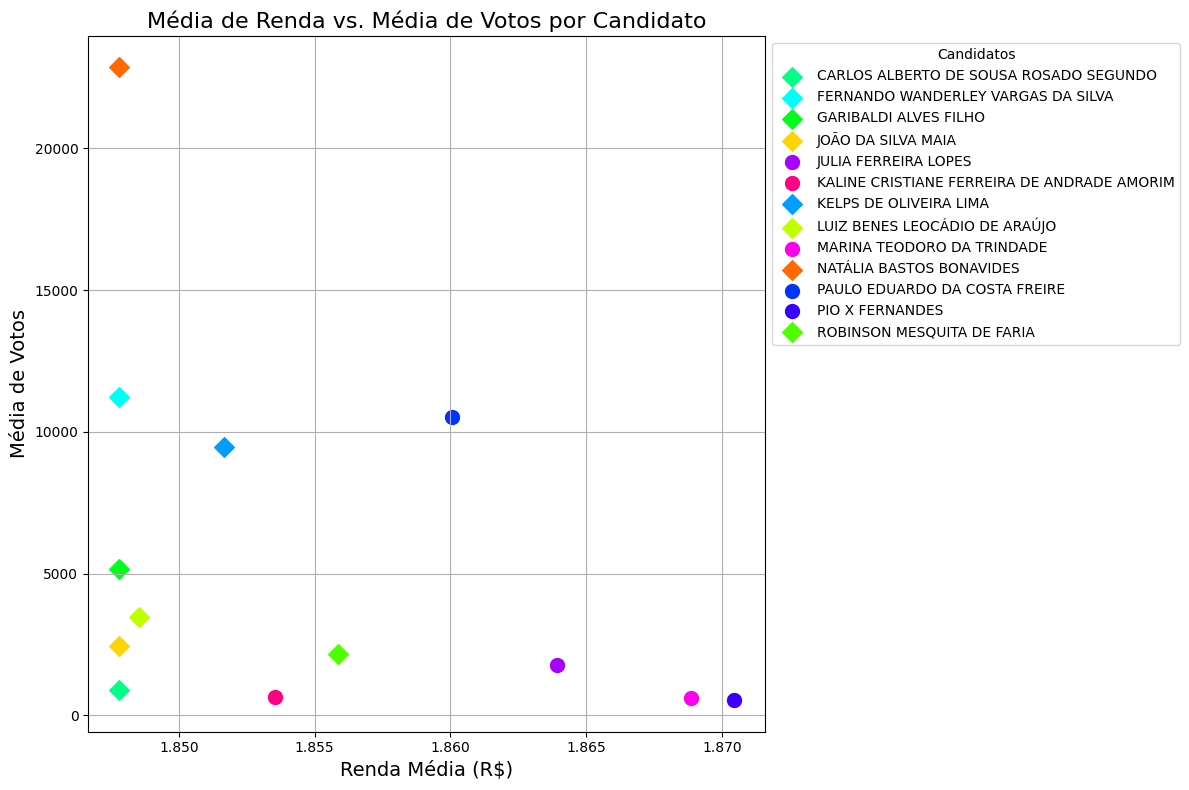

In [302]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Usar para gerar uma paleta de cores maior

# Lista de candidatos para análise
candidatos_selecionados = [
    'NATÁLIA BASTOS BONAVIDES', 'JOÃO DA SILVA MAIA',
    'LUIZ BENES LEOCÁDIO DE ARAÚJO', 'ROBINSON MESQUITA DE FARIA',
    'GARIBALDI ALVES FILHO', 'CARLOS ALBERTO DE SOUSA ROSADO SEGUNDO',
    'FERNANDO WANDERLEY VARGAS DA SILVA', 'KELPS DE OLIVEIRA LIMA', 
    'PAULO EDUARDO DA COSTA FREIRE', 'PIO X FERNANDES', 
    'JULIA FERREIRA LOPES', 'MARINA TEODORO DA TRINDADE', 
    'KALINE CRISTIANE FERREIRA DE ANDRADE AMORIM'
]

# Filtrar apenas os dados dos candidatos selecionados
df_candidatos = df_unificado[df_unificado['NM_VOTAVEL'].isin(candidatos_selecionados)]

# Agrupar votos por município e candidato
votos_por_municipio = df_candidatos.groupby(['NM_MUNICIPIO', 'NM_VOTAVEL'])['QT_VOTOS'].sum().reset_index()

# Colunas das faixas de renda e valores médios estimados para cada faixa
faixas_renda = ['Até 1/2', 'Mais de 1/2 a 1', 'Mais de 1 a 2', 'Mais de 2 a 5', 
                'Mais de 5 a 10', 'Mais de 10 a 20', 'Mais de 20']
valores_faixas = [0.25, 0.75, 1.5, 3.5, 7.5, 15, 20]  # Valores médios aproximados de cada faixa

# Garantir que não há valores nulos nas faixas de renda
df_unificado[faixas_renda] = df_unificado[faixas_renda].fillna(0)

# Somar as proporções para normalizar
soma_faixas = df_unificado[faixas_renda].sum(axis=1)

# Normalizar as faixas de renda (proporções somando 1 para cada município)
df_unificado[faixas_renda] = df_unificado[faixas_renda].div(soma_faixas, axis=0)

# Calcular a Renda Média ponderada
df_unificado['Renda Média'] = (df_unificado[faixas_renda] * valores_faixas).sum(axis=1)

# Combinar os votos com a renda média dos municípios
df_merged = pd.merge(votos_por_municipio, df_unificado[['NM_MUNICIPIO', 'Renda Média']], on='NM_MUNICIPIO')

# Calcular as médias por candidato
media_por_candidato = df_merged.groupby('NM_VOTAVEL').agg({
    'Renda Média': 'mean',
    'QT_VOTOS': 'mean'
}).reset_index()

# Lista dos deputados não eleitos
deputados_nao_eleitos = [
    'PAULO EDUARDO DA COSTA FREIRE', 'PIO X FERNANDES', 
    'JULIA FERREIRA LOPES', 'MARINA TEODORO DA TRINDADE', 
    'KALINE CRISTIANE FERREIRA DE ANDRADE AMORIM'
]

# Gerar uma paleta de cores com o número exato de candidatos
palette = sns.color_palette("hsv", len(candidatos_selecionados))  # Paleta de cores diversificada
candidato_cores = dict(zip(candidatos_selecionados, palette))  # Mapeia candidatos às cores

# Plotar apenas as médias por candidato
plt.figure(figsize=(12, 8))

for _, row in media_por_candidato.iterrows():
    candidato = row['NM_VOTAVEL']
    if candidato in deputados_nao_eleitos:
        # Usar bolinha para candidatos não eleitos
        plt.scatter(row['Renda Média'], row['QT_VOTOS'], label=candidato, 
                    color=candidato_cores[candidato], s=100, marker='o')  # Bolinhas
    else:
        # Usar losango para candidatos eleitos
        plt.scatter(row['Renda Média'], row['QT_VOTOS'], label=candidato, 
                    color=candidato_cores[candidato], s=100, marker='D')  # Losangos

# Configuração do gráfico
plt.title('Média de Renda vs. Média de Votos por Candidato', fontsize=16)
plt.xlabel('Renda Média (R$)', fontsize=14)
plt.ylabel('Média de Votos', fontsize=14)
plt.legend(title="Candidatos", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [303]:
# import matplotlib.pyplot as plt
# import random

# # Função para gerar uma cor aleatória
# def gerar_cor_aleatoria():
#     return [random.random(), random.random(), random.random()]

# # Plotar o gráfico de barras
# plt.figure(figsize=(10, 6))

# # Gerar uma lista de cores aleatórias para cada barra
# cores_aleatorias = [gerar_cor_aleatoria() for _ in range(len(votos_por_partido))]

# # Criar o gráfico de barras com cores aleatórias
# bars = plt.bar(votos_por_partido['Partido'], votos_por_partido['Media_Votos_por_Candidato'], color=cores_aleatorias)

# # Adicionar título e rótulos
# plt.title('Média de Votos por Candidato por Partido', fontsize=16)
# plt.xlabel('Partido', fontsize=14)
# plt.ylabel('Média de Votos por Candidato', fontsize=14)
# plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos dos partidos para melhor visualização

# # Adicionar o número de candidatos em cada barra com maior espaçamento
# for bar, candidatos in zip(bars, votos_por_partido['NM_VOTAVEL']):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.4, f'Candidatos: {candidatos}', 
#              ha='center', fontsize=10)

# # Exibir o gráfico
# plt.tight_layout()
# plt.show()


In [304]:
# pip install pandas sqlalchemy psycopg2

In [305]:
# from conexao import criar_conexao
# engine = criar_conexao()
# tabela='dados_eleitorais'
# df_unificado.to_sql(tabela, con=engine, if_exists='replace', index=False)

# print(f"Tabela '{tabela}' criada ou atualizada com sucesso no banco de dados!")

### 3-B

In [306]:
# Importando bibliotecas necessárias
import geopandas as gpd
import libpysal
from esda.moran import Moran
from pysal.lib import weights
import matplotlib.pyplot as plt

csv_path = 'Bases/Regioes_Geograficas.csv'
df_regioes = pd.read_csv(csv_path)
df_regioes['Nome_Distrito'] = df_regioes['Nome_Distrito'].apply(normalize_text)
df_regioes.head()

,UF,Nome_UF,Região Geográfica Intermediária,Nome Região Geográfica Intermediária,Região Geográfica Imediata,Nome Região Geográfica Imediata,Município,Código Município Completo,Nome_Município,Distrito,Código de Distrito Completo,Nome_Distrito
0,24,Rio Grande do Norte,2402,Caicó,240008,Currais Novos,109,2400109,Acari,5,240010905,ACARI
1,24,Rio Grande do Norte,2403,Mossoró,240011,Açu,208,2400208,Açu,5,240020805,ACU
2,24,Rio Grande do Norte,2403,Mossoró,240011,Açu,307,2400307,Afonso Bezerra,5,240030705,AFONSO BEZERRA
3,24,Rio Grande do Norte,2403,Mossoró,240010,Pau dos Ferros,406,2400406,Água Nova,5,240040605,AGUA NOVA
4,24,Rio Grande do Norte,2403,Mossoró,240010,Pau dos Ferros,505,2400505,Alexandria,5,240050505,ALEXANDRIA


In [307]:
# Normalizar os nomes dos municípios no dataframe de votos
df_votos_deputados['NM_MUNICIPIO'] = df_votos_deputados['NM_MUNICIPIO'].apply(normalize_text)

# Mapear municípios para microrregiões
df_votos_microrregioes = df_votos_deputados.merge(
    df_regioes[['Nome_Distrito', 'Nome Região Geográfica Imediata']],
    left_on='NM_MUNICIPIO',
    right_on='Nome_Distrito',
    how='inner'
)

# Agregando votos por microrregiões e candidatos
df_votos_por_microrregioes = df_votos_microrregioes.groupby(
    ['Nome Região Geográfica Imediata', 'NM_VOTAVEL']
)['QT_VOTOS'].sum().reset_index()

C:\Users\anafl\AppData\Local\Temp\ipykernel_211456\3584186299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votos_deputados['NM_MUNICIPIO'] = df_votos_deputados['NM_MUNICIPIO'].apply(normalize_text)


In [308]:
# Votos por candidato eleito
df_votos_deputados = df_votos[df_votos['NR_VOTAVEL'].astype(str).str.len() == 4]
df_votos_por_candidato_eleitos = (
    df_votos_deputados[~df_votos_deputados['NM_VOTAVEL'].isin(['VOTO BRANCO', 'VOTO NULO'])]
    .groupby('NM_VOTAVEL')['QT_VOTOS']
    .sum()
    .reset_index(name='QT_VOTOS_TOTAIS')
    .sort_values(by='QT_VOTOS_TOTAIS', ascending=False)
    .head(8)
)

# Dicionário com votos por município para os candidatos eleitos
total_votos_microrregiao = df_votos_por_microrregioes.groupby('Nome Região Geográfica Imediata')['QT_VOTOS'].sum().reset_index(name='QT_VOTOS_TOTAL_MICRORREGIAO')
dicionario_candidatos_eleitos_microrregiao = {
    candidato: (
        df_votos_por_microrregioes[df_votos_por_microrregioes['NM_VOTAVEL'] == candidato]
        .groupby('Nome Região Geográfica Imediata')['QT_VOTOS']
        .sum()
        .reset_index()
        .merge(total_votos_microrregiao, on='Nome Região Geográfica Imediata')
        .assign(percentual_votos=lambda x: round((x['QT_VOTOS'] / x['QT_VOTOS_TOTAL_MICRORREGIAO']) * 100, 1))
        .drop(columns='QT_VOTOS_TOTAL_MICRORREGIAO')
        .sort_values(by='percentual_votos', ascending=False)
    )
    for candidato in df_votos_por_candidato_eleitos['NM_VOTAVEL']
}

In [309]:
# Deputados federais eleitos e que tiveram mais de 50% em algum município
candidatos_eleitos_mais_50_por_cento_municipios = []

for candidato, df_candidato in dicionario_candidatos_eleitos_microrregiao.items():
    filtro = df_candidato[df_candidato['percentual_votos'] > 50]
    filtro = filtro.assign(NM_CANDIDATO=candidato)
    filtro = filtro[['NM_CANDIDATO', 'Nome Região Geográfica Imediata', 'percentual_votos']]
    candidatos_eleitos_mais_50_por_cento_municipios.append(filtro)

In [310]:
# Total de votos por microrregião
total_votos_microrregiao = df_votos_microrregioes.groupby('Nome Região Geográfica Imediata')['QT_VOTOS'].sum().reset_index()
total_votos_microrregiao.rename(columns={'QT_VOTOS': 'QT_VOTOS_TOTAL_MICRORREGIAO'}, inplace=True)

# Calculando percentual de votos por microrregião
df_votos_por_microrregioes = df_votos_por_microrregioes.merge(
    total_votos_microrregiao,
    on='Nome Região Geográfica Imediata'
)
df_votos_por_microrregioes['percentual_votos'] = (
    df_votos_por_microrregioes['QT_VOTOS'] / df_votos_por_microrregioes['QT_VOTOS_TOTAL_MICRORREGIAO']
) * 100

# Filtrando candidatos com mais de 50% dos votos em alguma microrregião
candidatos_mais_50_por_microrregiao = df_votos_por_microrregioes[
    df_votos_por_microrregioes['percentual_votos'] > 50
]

# Identificando candidatos eleitos e não eleitos
eleitos = df_votos_por_candidato_eleitos['NM_VOTAVEL'].unique()
candidatos_com_50_mais = candidatos_mais_50_por_microrregiao['NM_VOTAVEL'].unique()
eleitos_mais_50 = [candidato for candidato in eleitos if candidato in candidatos_com_50_mais]
eleitos_menos_50 = [candidato for candidato in eleitos if candidato not in candidatos_com_50_mais]
nao_eleitos_mais_50 = [candidato for candidato in candidatos_com_50_mais if candidato not in eleitos]

print("Deputados federais ELEITOS: \n", eleitos)
print("\nDeputados federais que FORAM ELEITOS e que TIVERAM MAIS DE 50% de votos em alguma microrregião: \n", eleitos_mais_50)
print("\nDeputados federais que FORAM ELEITOS e que NÃO TIVERAM MAIS DE 50% de votos em alguma microrregião: \n", eleitos_menos_50)
print("\nDeputados federais que TIVERAM MAIS DE 50% de votos em alguma microrregião mas que não foram eleitos: \n", nao_eleitos_mais_50)

Deputados federais ELEITOS: 
 ['NATÁLIA BASTOS BONAVIDES' 'JOÃO DA SILVA MAIA'
 'LUIZ BENES LEOCÁDIO DE ARAÚJO' 'ROBINSON MESQUITA DE FARIA'
 'GARIBALDI ALVES FILHO' 'CARLOS ALBERTO DE SOUSA ROSADO SEGUNDO'
 'FERNANDO WANDERLEY VARGAS DA SILVA' 'KELPS DE OLIVEIRA LIMA']

Deputados federais que FORAM ELEITOS e que TIVERAM MAIS DE 50% de votos em alguma microrregião: 
 []

Deputados federais que FORAM ELEITOS e que NÃO TIVERAM MAIS DE 50% de votos em alguma microrregião: 
 ['NATÁLIA BASTOS BONAVIDES', 'JOÃO DA SILVA MAIA', 'LUIZ BENES LEOCÁDIO DE ARAÚJO', 'ROBINSON MESQUITA DE FARIA', 'GARIBALDI ALVES FILHO', 'CARLOS ALBERTO DE SOUSA ROSADO SEGUNDO', 'FERNANDO WANDERLEY VARGAS DA SILVA', 'KELPS DE OLIVEIRA LIMA']

Deputados federais que TIVERAM MAIS DE 50% de votos em alguma microrregião mas que não foram eleitos: 
 []


In [311]:
'''
Identificar a microrregião com maior porcentagem de votos para cada candidato eleito
'''

# Lista de candidatos eleitos
candidatos_eleitos = df_votos_por_candidato_eleitos['NM_VOTAVEL'].unique()

# Filtrar apenas os dados dos candidatos eleitos
df_candidatos_eleitos = df_votos_por_microrregioes[df_votos_por_microrregioes['NM_VOTAVEL'].isin(candidatos_eleitos)]

# Identificar a microrregião com maior porcentagem de votos para cada candidato eleito
df_melhor_microrregiao = df_candidatos_eleitos.loc[
    df_candidatos_eleitos.groupby('NM_VOTAVEL')['percentual_votos'].idxmax()
].reset_index(drop=True)

# Selecionar apenas as colunas desejadas
df_melhor_microrregiao = df_melhor_microrregiao.rename(
    columns={
        'NM_VOTAVEL': 'NM_CANDIDATO',
        'Nome Região Geográfica Imediata': 'NM_MICRORREGIAO'
    }
)[['NM_CANDIDATO', 'NM_MICRORREGIAO', 'percentual_votos']]

# Exibir os resultados
df_melhor_microrregiao.sort_values(by='percentual_votos', ascending=False)

,NM_CANDIDATO,NM_MICRORREGIAO,percentual_votos
5,LUIZ BENES LEOCÁDIO DE ARAÚJO,João Câmara,21.128067
2,GARIBALDI ALVES FILHO,Santo Antônio - Passa e Fica - Nova Cruz,18.342223
7,ROBINSON MESQUITA DE FARIA,Santo Antônio - Passa e Fica - Nova Cruz,14.426170
3,JOÃO DA SILVA MAIA,João Câmara,11.495658
6,NATÁLIA BASTOS BONAVIDES,Caicó,11.113641
0,CARLOS ALBERTO DE SOUSA ROSADO SEGUNDO,Mossoró,10.599592
4,KELPS DE OLIVEIRA LIMA,Santo Antônio - Passa e Fica - Nova Cruz,7.098194
1,FERNANDO WANDERLEY VARGAS DA SILVA,Natal,6.151112


### 3-D

In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = 'Bases/Rendimento.csv'
df_adicional = pd.read_csv(csv_path)

df_adicional['Distrito'] = df_adicional['Distrito'].apply(normalize_text)
df_unificado['NM_MUNICIPIO'] = df_unificado['NM_MUNICIPIO'].apply(normalize_text)

df_merged = df_unificado.merge(
    df_adicional,
    left_on='NM_MUNICIPIO',
    right_on='Distrito',
    how='inner'
)

df_merged.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,SG_UF,SG_UE,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,CD_CARGO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,SQ_CANDIDATO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,CD_DIST,NM_MUN,NM_DIST,Total_setores,Pessoas,Domicílios,Domicílios Particulares,Domicílios Coletivos,Média de moradores em DPOs,Percentual de DPOs Imputados,Domicílios Particulares Ocupados,Distrito_x,Total Indivíduos,Até 1/2_x,Mais de 1/2 a 1_x,Mais de 1 a 2_x,Mais de 2 a 5_x,Mais de 5 a 10_x,Mais de 10 a 20_x,Mais de 20_x,Sem rendimento_x,Código da Unidade Geográfica_x,Renda Média,Distrito_y,Total,Até 1/2_y,Mais de 1/2 a 1_y,Mais de 1 a 2_y,Mais de 2 a 5_y,Mais de 5 a 10_y,Mais de 10 a 20_y,Mais de 20_y,Sem rendimento_y,Código da Unidade Geográfica_y
0,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,16217,AREIA BRANCA,32,24,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,3,1155,200001608805,ESCOLA MUNICIPAL COMERCIAL PROFESSORA GERALDA ...,"RUA JORGE CAMINHA, 118",2,Nordeste,24,Rio Grande do Norte,2401107,240110705,AREIA BRANCA,AREIA BRANCA,42,24093,11691,11680,11,2.942442,2.835146,8183,Areia Branca,21514,0.173124,0.436734,0.225519,0.128740,0.030734,0.004496,0.000654,9276,2401107,1.470717,AREIA BRANCA,21514,2118,5343,2759,1575,376,55,8,9276,2401107
1,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,18279,SANTANA DO MATOS,18,119,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,85,1147,200001608805,ESCOLA MUNICIPAL LUIZ LIBERALINO DE CARVALHO,"POVOADO BOM JESUS, S/N",2,Nordeste,24,Rio Grande do Norte,2411403,241140305,SANTANA DO MATOS,SANTANA DO MATOS,17,8688,4192,4190,2,2.769525,0.127510,3137,Santana do Matos,11873,0.337366,0.524895,0.092756,0.035676,0.007135,0.001396,0.000776,5426,2411403,0.831976,SANTANA DO MATOS,11873,2175,3384,598,230,46,9,5,5426,2411403
2,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,17612,NATAL,4,308,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,5,1546,200001608805,ESCOLA ESTADUAL ANTONIO PINTO DE MEDEIROS,"RUA RIO PARANAPANEMA, S/N - CONJUNTO CIDADE SA...",2,Nordeste,24,Rio Grande do Norte,2408102,240810205,NATAL,NATAL,1116,751300,337029,336655,374,2.772461,3.632069,270507,Natal,695027,0.074512,0.375586,0.262966,0.166311,0.074408,0.033312,0.012906,253853,2408102,2.592709,NATAL,695027,32863,165649,115979,73350,32817,14692,5692,253853,2408102
3,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,17493,MAXARANGUAPE,64,39,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,43,1066,200001608805,ESCOLA MUNICIPAL PROFESSOR ESMERINO GOMES DE S...,"RUA DA MACAÍBA, SN - PRAIA DE CARAUBAS",2,Nordeste,24,Rio Grande do Norte,2407500,240750005,MAXARANGUAPE,MAXARANGUAPE,23,10255,5576,5564,12,3.181790,0.590429,3218,Maxaranguape,8365,0.246423,0.528080,0.162503,0.046124,0.011745,0.003844,0.001281,3682,2407500,1.034220,MAXARANGUAPE,8365,1154,2473,761,216,55,18,6,3682,2407500
4,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,546,ELEIÇÕES GERAIS ESTADUAIS 2022,02/10/2022,E,RN,RN,RIO GRANDE DO NORTE,17876,PAU DOS FERROS,40,89,6,DEPUTADO FEDERAL,4444,LUIZ BENES LEOCÁDIO DE ARAÚJO,1,1139,200001608805,ESCOLA ESTADUAL TEOFILO REGO,"RUA DA INDEPENDENCIA, 60",2,Nordeste,24,Rio Grande do Norte,2409407,240940705,PAU DOS FERROS,PAU DOS FERROS,41,30479,13051,13041,10,2.805045,1.938416,10782,Pau dos Ferros,23678,0.159643,0.515194,0.174568,0.108252,0.031064,0.008644,0.002634,8869,2409407,1.482358,PAU DOS FERROS,23678,2364,7629,2585,1603,460,128,39,8869,2409407


In [313]:
# Identify the correct columns for the income ranges in the merged DataFrame
income_columns = [
    col for col in df_merged.columns if any(
        faixa in col for faixa in ['Até 1/2', 'Mais de 1/2 a 1', 'Mais de 1 a 2',
                                   'Mais de 2 a 5', 'Mais de 5 a 10', 'Mais de 10 a 20', 'Mais de 20']
    )
]

# Ensure we're only using one set of columns (e.g., '_x' or '_y')
# Assuming '_x' contains the relevant data; adjust if needed
income_columns = [col for col in income_columns if col.endswith('_x')]

# Rename the columns to remove suffixes for consistency
df_merged.rename(columns={col: col.rstrip('_x') for col in income_columns}, inplace=True)

# Filter the income columns for further processing
faixas_renda = [col.rstrip('_x') for col in income_columns]

# Ensure there are no missing values in these columns
df_merged[faixas_renda] = df_merged[faixas_renda].fillna(0)

# Calculate correlations between vote totals and income ranges
df_corr = df_merged.groupby('NM_VOTAVEL').apply(
    lambda group: pd.Series({
        faixa: group['QT_VOTOS'].corr(group[faixa])
        for faixa in faixas_renda
    })
).reset_index()

# Rename columns for better readability
df_corr.columns = ['NM_VOTAVEL'] + faixas_renda

C:\Users\anafl\AppData\Local\Temp\ipykernel_211456\982613526.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_corr = df_merged.groupby('NM_VOTAVEL').apply(


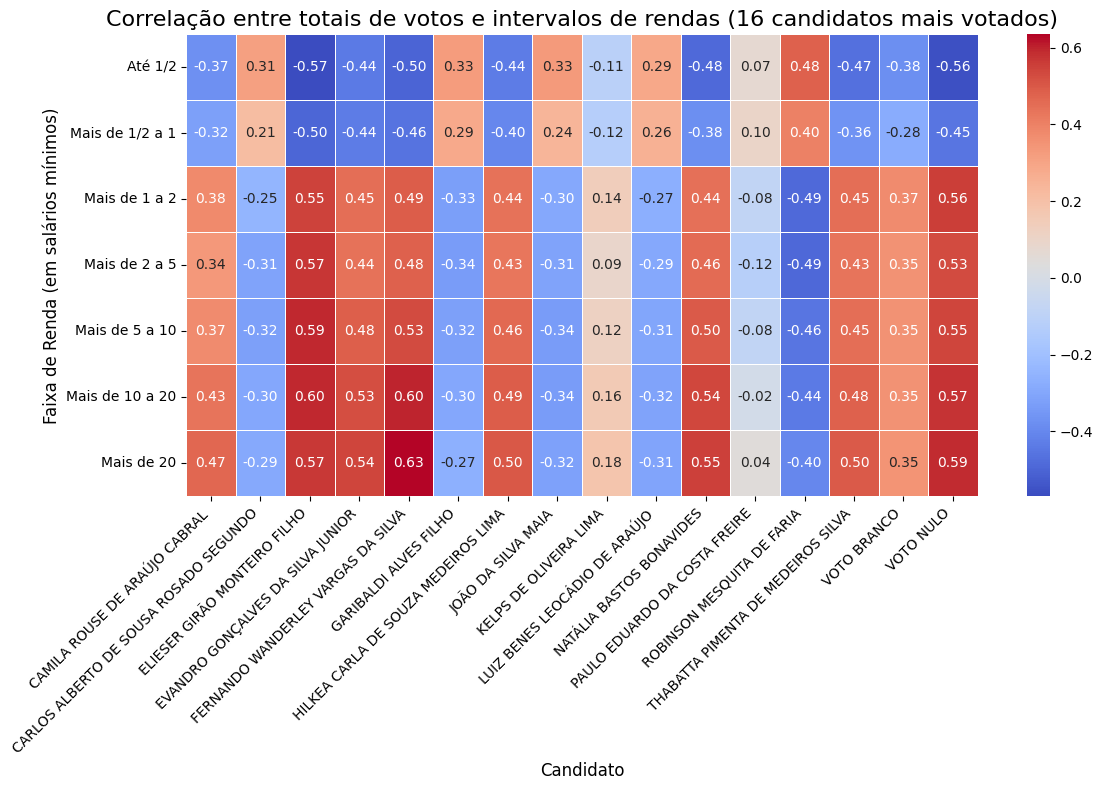

In [314]:
# Filtrar os 16 candidatos mais votados
top_candidatos = df_merged.groupby('NM_VOTAVEL')['QT_VOTOS'].sum().nlargest(16).index

# Filtrar o DataFrame de correlações para incluir apenas esses candidatos
df_corr_top = df_corr[df_corr['NM_VOTAVEL'].isin(top_candidatos)]

# Visualizar as correlações dos 16 candidatos mais votados em um heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_corr_top.set_index('NM_VOTAVEL').transpose(),
    annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5
)
plt.title('Correlação entre totais de votos e intervalos de rendas (16 candidatos mais votados)', fontsize=16)
plt.ylabel('Faixa de Renda (em salários mínimos)', fontsize=12)
plt.xlabel('Candidato', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [315]:
# Calcular estatísticas gerais para análise de correlação
cor_stats = df_corr[faixas_renda].describe().transpose()
print("Estatísticas gerais das correlações por faixa de renda:")
cor_stats

Estatísticas gerais das correlações por faixa de renda:


,count,mean,std,min,25%,50%,75%,max
Até 1/2,201.0,-0.003070,0.211857,-0.569627,-0.131877,-0.021997,0.134533,0.487784
Mais de 1/2 a 1,201.0,-0.009397,0.211239,-0.495162,-0.130250,-0.029163,0.136460,0.520045
Mais de 1 a 2,201.0,0.005418,0.210224,-0.486779,-0.137411,0.040537,0.137670,0.556386
Mais de 2 a 5,201.0,0.007777,0.220645,-0.490546,-0.165452,0.024144,0.126409,0.569733
Mais de 5 a 10,201.0,0.000649,0.227104,-0.455360,-0.190414,0.017163,0.135050,0.594872
Mais de 10 a 20,201.0,-0.011134,0.225550,-0.448264,-0.193657,0.004548,0.140954,0.599114
Mais de 20,201.0,-0.023565,0.228007,-0.413218,-0.189002,-0.061400,0.129645,0.634628
